## CSC 177-02 Data Warehousing and Data Mining
### Mini-Project 1: Clustering
### 2016 US presedential election Twitter analysis

#### Group members: Aaron Enberg,

In [1]:
import pandas as pd
import sklearn.feature_extraction.text as sk_text
pd.set_option('display.max_colwidth', -1)

In [2]:
column_names = ['Name', 'screen_Name', 'User_ID', 
                'Followers_Count', 'Friends_Count', 
                'Location', 'Description', 'Created_At', 
                'Status_ID', 'Language', 'Place', 
                'Retweet_Count', 'Favorite_Count', 'Text']
tweets = pd.read_table('data/clinton_trump_tweets.txt', names=column_names, encoding='ISO-8859-1')
tweets.columns = tweets.columns.str.lower()

In [3]:
tweets.shape

(5250980, 14)

In [4]:
tweets.dtypes

name               object
screen_name        object
user_id            int64 
followers_count    int64 
friends_count      int64 
location           object
description        object
created_at         object
status_id          int64 
language           object
place              object
retweet_count      int64 
favorite_count     int64 
text               object
dtype: object

## Preprocessing

In [5]:
tweets.drop(['name', 'screen_name', 
            'followers_count', 
            'friends_count', 
            'location', 
            'description', 
            'created_at',
            'status_id', 
            'language', 
            'place', 
            'retweet_count', 
            'favorite_count'], axis=1, inplace=True)

In [6]:
tweets.head(n=10)

,user_id,text
0,1519696717,@NWAJimmy I've read it now though brother. Was pretty spot on Lots of bright spots but a lot to work on. Exactly as an exhibition should be!
1,109945090,RT @wikileaks: New poll puts Pirate Party on course to win Iceland's national elections on Saturday. https://t.co/edTqjeJaQ6
2,1450086582,@gaystoner821 I think New Orleans spoiled me with food. I need to try and branch out in BR.
3,167177185,RT @LOLGOP: ACA needs fixes but know da facts: *70% can get covered in marketplaces for under $75/month *Hikes affect 3% *GOP will uninsu
4,1191022351,RT @FastCompany: Alphabet shares soar on better-than-expected earnings as mobile video strategy pays off https://t.co/bokbXngMJt https://t.
5,154393802,RT @Pattric: That one follower who tweet you everyday and even tho you don't respond they still be @'ing you https://t.co/QBeQyc2PO6
6,106568768,#infosec #Intel #ACM #IEEE Impacts Haswell microarch. Paper proposes mitigations that could prevent BTB-based side https://t.co/DW6vgRAPrv
7,17101060,"Hacked e-mails show Clinton campaigns fears about Sanders | https://t.co/WMyCHuCDIc The Philippine Star (PhilippineStar) October 28, 2"
8,17352518,RT @africaarguments: This year's seen some remarkable new films by African directors. Here are a few of them. https://t.co/9JEY4ubGVE http
9,2352007196,"RT @HalifaxEditor: Some 40 years later, @HfxRegPolice continue to investigate the murder of Florence Ann Keeble. https://t.co/axdvA1HUcu ht"


In [7]:
pattern = r'^RT\s'
 
# matches retweets and removes them
tweets = tweets[tweets.text.str.match(pattern) == False]

In [8]:
tweets.shape

(2416818, 2)

In [9]:
tweets.head(n=10)

,user_id,text
0,1519696717,@NWAJimmy I've read it now though brother. Was pretty spot on Lots of bright spots but a lot to work on. Exactly as an exhibition should be!
2,1450086582,@gaystoner821 I think New Orleans spoiled me with food. I need to try and branch out in BR.
6,106568768,#infosec #Intel #ACM #IEEE Impacts Haswell microarch. Paper proposes mitigations that could prevent BTB-based side https://t.co/DW6vgRAPrv
7,17101060,"Hacked e-mails show Clinton campaigns fears about Sanders | https://t.co/WMyCHuCDIc The Philippine Star (PhilippineStar) October 28, 2"
10,16818809,Hulk smash!
12,163712593,"Well, I'm glad you got a good haircut, America's in the toilet. Is this not a conversation @Haylie_Bre and I woul https://t.co/6dVIIKZcgv"
13,2447279666,@WayneDupreeShow #climatechange is the democrats' attempt to play God
18,231921777,OH MY GOD. TEARS. https://t.co/8odjnHZwRK
20,235657662,"no lie, I been waiting for tony's story https://t.co/S5i4ESNilb"
21,201499452,How a dot-com millionaire became a social media crusader against solar amendment: It was a violation of Googl... https://t.co/ychypPZpKd


In [10]:
# match all hashtags and mentions in a tweet, ignoring possible email addresses
pattern = r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z_]+[A-Za-z0-9_]+)|(?<=^|(?<=[^a-zA-Z0-9-\.]))#([A-Za-z_]+[A-Za-z0-9_]+)'

""" returns a DataFrame with a MultiIndex:
    First index is our original index. Second index is "match" which is a running
    total of the number of occurences of hashtags and mentions for a particular 
    tweet. """
handles_hashtags = tweets.text.str.extractall(pattern)

In [11]:
handles_hashtags.columns = ['handles', 'hashtags']
handles_hashtags = handles_hashtags.reset_index().set_index('level_0')
del handles_hashtags.index.name
handles_hashtags.drop(['match'], axis=1, inplace=True)
# stack handles and hashtags into one column
handles_hashtags = pd.concat([handles_hashtags.handles, handles_hashtags.hashtags]).dropna().to_frame(name='handles_hashtags')

In [12]:
''' returns users along with all the hashtags/handles they've used 
    (each occurrence of a hashtag/handle will also show up in the list) '''
tweets = tweets.join(handles_hashtags, how='inner')
tweets.drop(['text'], axis=1, inplace=True)
handles_hashtags_all = tweets.reset_index().groupby('user_id')['handles_hashtags'].apply(list).to_frame()

In [13]:
handles_hashtags_all.head(n=10)

,handles_hashtags
user_id,
150,"[flangy, nelson, fjordinn, shinypb, fjordinn, fjordinn, iano, thatstacy, utilizer001, Carricohimself, fjordinn, raffi, d6, Sonikku_a, doctorow, gwestr]"
1437,"[overheardinlondon, whodeyintheUK, JimOwczarski, whodeyintheUK, AirlineFlyer, AirlineFlyer]"
1512,"[mozilla, david_bryant, SenFeinstein, marypcbuk]"
1644,"[MaryLovesBooks, BookNerdParadis, matt_hearnden, success, perspective, life, CodyBLister, Marketing, nick_eubanks, contentmarketing, promotionftw, contentmarketing, fredrivett, RobWormley, ContentMarketing, LArtra, BookNerdParadis, adamjayc, bloggingwizard, GuestBloggingStrategy, TamieDearen, BookNerdParadis, JRRTolkien, KatyHuthJones, BookNerdParadis, LorilynRoberts, BookNerdParadis, _awtozer, rahdieh, BookNerdParadis, TolkienQuote, EliseKova, BookNerdParadis, startrailsIV, BookNerdParadis, FebruaryGrace, BookNerdParadis, rtmixmktg, raecarson, BookNerdParadis, WillBluntAU, ContentMarketing, blog, LaurenLynneYA, BookNerdParadis, listbuilding, guestposting, motivation, success, emailmarketing, CRO]"
1668,[garrytan]
1737,"[nehanarkhede, ATO2016, erinscafe, MailChimp, ATO2016, rachaelmaddux, _raven_io, pwnela, GregU, PTC, Vuforia, ATO2016, nehanarkhede, erinscafe, salrelish, KyFaSt, nehanarkhede, MailChimp, ATO2016, SwiftOnSecurity, dcloues, nehanarkhede, jessfraz, erinscafe, nehanarkhede, solrac901, ApacheSpot, MailChimp, ATO2016, adickerson, ComfortablySmug, jdickerson, skamille, Michael_Tsunam1, samnesmith, bakins, JessicaMauerhan]"
2294,[qz]
2311,"[wp, ischafer, TeslaMotors, levie, SlackHQ, worldseries, hitlist_app, wandertab]"
2391,"[NathanFGao, bonaventuresoft, presserb, petshopboys, eldescanso, buzz, andymatic, petshopboys, mknepprath, dansinker, willsh, j3sse_pub, petshopboys, thelastwalt, tonx, MikeIsaac, fmanjoo, migurski, rtraister, atrubens, twitter, j3sse_pub, petshopboys, clearwriter, twitter, timbuckwalter, scarequotes, kathrynyu, summersumz, steveportigal, billder, NathanFGao, robynkanner, thelastwalt, clearwriter, hhavrilesky, TheCut, tonx, bjheinley, kowitz, yodamay, BenKennerly, michael, MaxTemkin, lmc, nczeitgeist, kathrynyu, dansays, tonx, Annaleen, TimGunn, atrubens, twitter, mnik]"


### active users with at least 20 distinct hashtags/handles

In [14]:
# returns users along with the distinct hashtags/handles they've used
handles_hashtags_distinct = tweets.reset_index().groupby('user_id')['handles_hashtags'].unique().to_frame()
# retrieve only those who have used 20 or more distinct handles/hashtags
users_active = handles_hashtags_distinct[handles_hashtags_distinct.handles_hashtags.str.len() > 19]

In [15]:
users_active = users_active.join(handles_hashtags_all, lsuffix='_distinct', rsuffix='_all', how='inner')

In [16]:
users_active.head()

,handles_hashtags_distinct,handles_hashtags_all
user_id,,
1644,"[MaryLovesBooks, BookNerdParadis, matt_hearnden, success, perspective, life, CodyBLister, Marketing, nick_eubanks, contentmarketing, promotionftw, fredrivett, RobWormley, ContentMarketing, LArtra, adamjayc, bloggingwizard, GuestBloggingStrategy, TamieDearen, JRRTolkien, KatyHuthJones, LorilynRoberts, _awtozer, rahdieh, TolkienQuote, EliseKova, startrailsIV, FebruaryGrace, rtmixmktg, raecarson, WillBluntAU, blog, LaurenLynneYA, listbuilding, guestposting, motivation, emailmarketing, CRO]","[MaryLovesBooks, BookNerdParadis, matt_hearnden, success, perspective, life, CodyBLister, Marketing, nick_eubanks, contentmarketing, promotionftw, contentmarketing, fredrivett, RobWormley, ContentMarketing, LArtra, BookNerdParadis, adamjayc, bloggingwizard, GuestBloggingStrategy, TamieDearen, BookNerdParadis, JRRTolkien, KatyHuthJones, BookNerdParadis, LorilynRoberts, BookNerdParadis, _awtozer, rahdieh, BookNerdParadis, TolkienQuote, EliseKova, BookNerdParadis, startrailsIV, BookNerdParadis, FebruaryGrace, BookNerdParadis, rtmixmktg, raecarson, BookNerdParadis, WillBluntAU, ContentMarketing, blog, LaurenLynneYA, BookNerdParadis, listbuilding, guestposting, motivation, success, emailmarketing, CRO]"
1737,"[nehanarkhede, ATO2016, erinscafe, MailChimp, rachaelmaddux, _raven_io, pwnela, GregU, PTC, Vuforia, salrelish, KyFaSt, SwiftOnSecurity, dcloues, jessfraz, solrac901, ApacheSpot, adickerson, ComfortablySmug, jdickerson, skamille, Michael_Tsunam1, samnesmith, bakins, JessicaMauerhan]","[nehanarkhede, ATO2016, erinscafe, MailChimp, ATO2016, rachaelmaddux, _raven_io, pwnela, GregU, PTC, Vuforia, ATO2016, nehanarkhede, erinscafe, salrelish, KyFaSt, nehanarkhede, MailChimp, ATO2016, SwiftOnSecurity, dcloues, nehanarkhede, jessfraz, erinscafe, nehanarkhede, solrac901, ApacheSpot, MailChimp, ATO2016, adickerson, ComfortablySmug, jdickerson, skamille, Michael_Tsunam1, samnesmith, bakins, JessicaMauerhan]"
2391,"[NathanFGao, bonaventuresoft, presserb, petshopboys, eldescanso, buzz, andymatic, mknepprath, dansinker, willsh, j3sse_pub, thelastwalt, tonx, MikeIsaac, fmanjoo, migurski, rtraister, atrubens, twitter, clearwriter, timbuckwalter, scarequotes, kathrynyu, summersumz, steveportigal, billder, robynkanner, hhavrilesky, TheCut, bjheinley, kowitz, yodamay, BenKennerly, michael, MaxTemkin, lmc, nczeitgeist, dansays, Annaleen, TimGunn, mnik]","[NathanFGao, bonaventuresoft, presserb, petshopboys, eldescanso, buzz, andymatic, petshopboys, mknepprath, dansinker, willsh, j3sse_pub, petshopboys, thelastwalt, tonx, MikeIsaac, fmanjoo, migurski, rtraister, atrubens, twitter, j3sse_pub, petshopboys, clearwriter, twitter, timbuckwalter, scarequotes, kathrynyu, summersumz, steveportigal, billder, NathanFGao, robynkanner, thelastwalt, clearwriter, hhavrilesky, TheCut, tonx, bjheinley, kowitz, yodamay, BenKennerly, michael, MaxTemkin, lmc, nczeitgeist, kathrynyu, dansays, tonx, Annaleen, TimGunn, atrubens, twitter, mnik]"
2426,"[MikeIsaac, thelancearthur, FFWglobal, SenFeinstein, shootatweet, NancyPelosi, abookapart, SenatorBoxer, GOP, united, designhawg, JoeGermuska, knightlab, Real_TJ_Thomas, gruber, parisvega, espiekermann, MikeHosier, ChappellTracker, drwave, beaucolburn, choad, halvorson, facebook, sjarvis, zeldman, natts, astronautpnguin, matt_timmons, austinkleon, de5igner, madebyfew, gunsonfacebookrightnow, romanmars, mat, sonia__harris, SherylCababa, dansinker, facebooks, jbsibley, blocktogether, ToddRoss, MxF2016]","[MikeIsaac, thelancearthur, FFWglobal, SenFeinstein, shootatweet, SenFeinstein, shootatweet, NancyPelosi, shootatweet, abookapart, SenatorBoxer, shootatweet, GOP, united, designhawg, JoeGermuska, knightlab, MikeIsaac, NancyPelosi, shootatweet, NancyPelosi, shootatweet, Real_TJ_Thomas, gruber, SenatorBoxer, shootatweet, parisvega, espiekermann, MikeHosier, ChappellTracker, drwave, beaucolburn, choad, halvorson, NancyPelosi, shootatweet, designhawg, SenFeinstein, shootatweet, Sena

In [17]:
users_active['handles_hashtags_stringified'] = users_active['handles_hashtags_all'].apply(lambda x: ' '.join(map(str, x)))

In [18]:
corpus = list(users_active['handles_hashtags_stringified'])

In [19]:
''' each string in the list contains all the hashtags/handles for one user 
    (contains duplicates if they used a hashtag/handle more than once) '''
corpus

['MaryLovesBooks BookNerdParadis matt_hearnden success perspective life CodyBLister Marketing nick_eubanks contentmarketing promotionftw contentmarketing fredrivett RobWormley ContentMarketing LArtra BookNerdParadis adamjayc bloggingwizard GuestBloggingStrategy TamieDearen BookNerdParadis JRRTolkien KatyHuthJones BookNerdParadis LorilynRoberts BookNerdParadis _awtozer rahdieh BookNerdParadis TolkienQuote EliseKova BookNerdParadis startrailsIV BookNerdParadis FebruaryGrace BookNerdParadis rtmixmktg raecarson BookNerdParadis WillBluntAU ContentMarketing blog LaurenLynneYA BookNerdParadis listbuilding guestposting motivation success emailmarketing CRO',
 'nehanarkhede ATO2016 erinscafe MailChimp ATO2016 rachaelmaddux _raven_io pwnela GregU PTC Vuforia ATO2016 nehanarkhede erinscafe salrelish KyFaSt nehanarkhede MailChimp ATO2016 SwiftOnSecurity dcloues nehanarkhede jessfraz erinscafe nehanarkhede solrac901 ApacheSpot MailChimp ATO2016 adickerson ComfortablySmug jdickerson skamille Michael

### hashtags/handles that have been used by at least 20 distinct users (min_df=20)

In [20]:
# constructs a dataframe with only the handles/hashtags used by 20 users 
vectorizer = sk_text.CountVectorizer(min_df=20, lowercase=True, encoding='ISO-8859-1')
matrix = vectorizer.fit_transform(corpus)
df = pd.DataFrame(matrix.toarray(), index=users_active.index, columns=vectorizer.get_feature_names())

In [21]:
# columns are hashtags and handles and values are frequency of handle/hashtag for a given user
df.head()

,_altright_anew,_carja,_cfj_,_makada_,_proud_american,_realvalentina_,a_miller48,abbydphillip,abbymartin,abbymartinm,...,zachhaller,zaibatsunews,zaidjilani,zekejmiller,zerohedge,zhaabowekwe,zigmanfreud,zika,zimmermanrob,zip90210
user_id,,,,,,,,,,,,,,,,,,,,,
1644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df.shape

(17066, 4035)

In [23]:
# same matrix just swapped rows and columns
df.transpose().head()

user_id,1644,1737,2391,2426,14763,1026541,1134681,1201691,1253141,1329901,...,2519981617,2520294360,2520480397,2520487656,2520839886,2521149576,2521541502,2521805227,2521929295,2522444346
_altright_anew,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_carja,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_cfj_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_makada_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_proud_american,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df[0:10].sum(axis=1)

user_id
1644       11 
1737       5  
2391       7  
2426       27 
14763      6  
1026541    44 
1134681    46 
1201691    45 
1253141    0  
1329901    223
dtype: int64

In [25]:
df.shape

(17066, 4035)

Begin Clustering


In [26]:
import numpy as np
import sklearn.metrics as metrics
from sklearn import preprocessing as skp

In [27]:
import sklearn.cluster as sk_cluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline



In [28]:
df_p1 = df.transpose()


In [29]:
df_p1.head()


user_id,1644,1737,2391,2426,14763,1026541,1134681,1201691,1253141,1329901,...,2519981617,2520294360,2520480397,2520487656,2520839886,2521149576,2521541502,2521805227,2521929295,2522444346
_altright_anew,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_carja,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_cfj_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_makada_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_proud_american,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_p1_std = skp.normalize(df_p1, norm='l2', axis=1)

Text(0,0.5,'SSE')

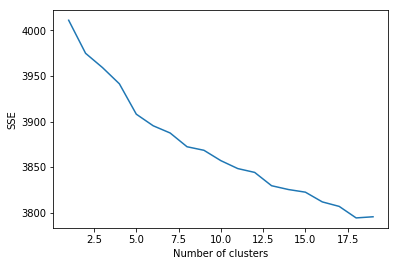

In [31]:
error = np.zeros(20)
for k in range(1,20):
    kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(df_p1_std)
    error[k] = kmeans.inertia_

plt.plot(range(1, 20),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

In [32]:
kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=5, n_init=10, max_iter=300)  

kmeans.fit_predict(df_p1_std)

print ('\n Cluster Centroids')
centroids = kmeans.cluster_centers_
print (centroids)

print ('\nCluster labels')
kmeans_labels = kmeans.labels_
print(kmeans_labels)


print('\n')
error = kmeans.inertia_      
print ("The total error of the clustering is: ", error)


 Cluster Centroids
[[  1.21972744e-19   7.99599102e-19  -9.35124374e-19 ...,  -5.28548559e-19
    4.34288433e-04  -3.86247024e-19]
 [  4.62922740e-05   1.07475982e-04   1.21381169e-04 ...,   1.27782071e-04
    7.66370386e-04   6.65278364e-05]
 [  6.77626358e-21  -1.35525272e-19   6.77626358e-20 ...,   1.04450989e-04
   -3.25260652e-19  -9.48676901e-20]
 [ -2.03287907e-20   0.00000000e+00   5.42101086e-20 ...,   1.35525272e-20
    2.35513925e-04  -2.03287907e-20]
 [  2.71050543e-20  -1.76182853e-19   6.77626358e-20 ...,   6.77626358e-20
   -5.42101086e-19  -1.01643954e-19]]

Cluster labels
[1 1 4 ..., 1 1 0]


The total error of the clustering is:  3909.6014648


In [33]:
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
for x in kmeans_labels:
    if x == 0:
        count1 = count1 + 1
    if x == 1:
        count2 = count2 + 1
    if x == 2:
        count3 = count3 + 1
    if x == 3:
        count4 = count4 + 1
    if x == 4:
        count5 = count5 + 1
print(count1)
print(count2)
print(count3)
print(count4)
print(count5)


559
3291
66
40
79


Agglomerative Clustering

In [39]:
ag = sk_cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = 5)   

ag_labels = ag.fit_predict(df_p1_std)
ag_labels

array([0, 0, 0, ..., 0, 0, 0])

{'color_list': ['g',
  'g',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'r',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'c',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'm',
  'm',
  'm',
  'b',
  'b',
  'y',
  'b',
  'k',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'b',
  'b',
  'b',
  'b',
  'b',
  'c',
  'b',
  'b',
  'b',
  'b',
  'b',
  'm',
  'm',
  'm',
  'm',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'b',
  'y',
  'y',
  'y',
  'b',
  'b',
  'b',
  'b',
  'b',
  'k',
  'k',
  'k',
  'k',
  'k',
  'b',
  'g',
  'g',
  'g',
  'g',
  'r',
  'r',
  'b',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'b',
  'b',
  'b',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',
  'm',

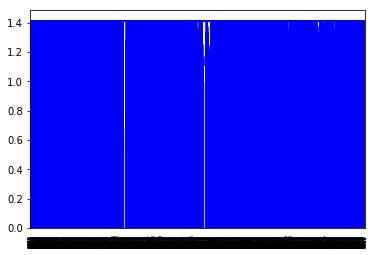

In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage      

ag = linkage(df_p1_std, method='complete')       # Performs agglomerative clustering with MAX metric

dendrogram(ag)